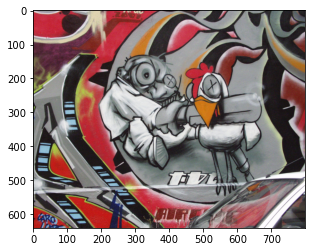

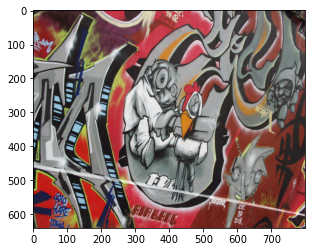

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pymagsac
from time import time

img1 = cv2.cvtColor(cv2.imread('../data/homography/grafA.png'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('../data/homography/grafB.png'), cv2.COLOR_BGR2RGB)
H_gt = np.linalg.inv(np.loadtxt('../data/homography/graf_model.txt'))
plt.imshow(img1)
plt.figure()
plt.imshow(img2)

In [2]:
#We will detect ORB features and match them with cross-check test
det = cv2.SIFT_create(8000)    
kps1, descs1 = det.detectAndCompute(img1,None)
kps2, descs2 = det.detectAndCompute(img2,None)

bf = cv2.BFMatcher()

SNN_threshold = 0.85
matches = bf.knnMatch(descs1, descs2, k=2)

# Apply ratio test
snn_ratios = []
tentatives = []
for m, n in matches:
    if m.distance < SNN_threshold * n.distance:
        tentatives.append(m)
        snn_ratios.append(m.distance / n.distance)

# Sort the points according to the SNN ratio.
# This step is required both for PROSAC and P-NAPSAC.
sorted_indices = np.argsort(snn_ratios)
tentatives = list(np.array(tentatives)[sorted_indices])

In [3]:
#Now, some visualization from OpenCV tutorial
#https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
#We will draw correspondences found and the geometric transformation between the images.
from copy import deepcopy
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
def draw_matches(kps1, kps2, tentatives, img1, img2, H, mask):
    if H is None:
        print ("No homography found")
        return
    matchesMask = mask.ravel().tolist()
    h,w,ch = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, H)
    #Ground truth transformation
    dst_GT = cv2.perspectiveTransform(pts, H_gt)
    img2_tr = cv2.polylines(decolorize(img2),[np.int32(dst)],True,(0,0,255),3, cv2.LINE_AA)
    img2_tr = cv2.polylines(deepcopy(img2_tr),[np.int32(dst_GT)],True,(0,255,0),3, cv2.LINE_AA)
    # Blue is estimated, green is ground truth homography
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   flags = 2)
    inliers = [tentatives[k] for k in range(len(matchesMask)) if matchesMask[k] == 1]
    img_out = cv2.drawMatches(decolorize(img1),kps1,img2_tr,kps2,inliers,None,**draw_params)
    plt.figure(figsize = (12,8))
    plt.imshow(img_out)
    return

In [4]:
img1.shape

(640, 800, 3)

Note that the inlier number does not determine the quality of the solution since MAGSAC and MAGSAC++ does not return inliers. The ones shown are selected by using a dummy threshold.
393.0 inliers found
0.010330438613891602  sec cv2
467.0 inliers found
0.020863056182861328  sec magsac++
459.0 inliers found
0.013113737106323242  sec magsac


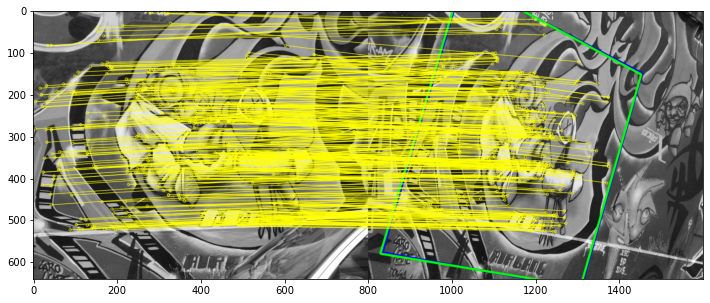

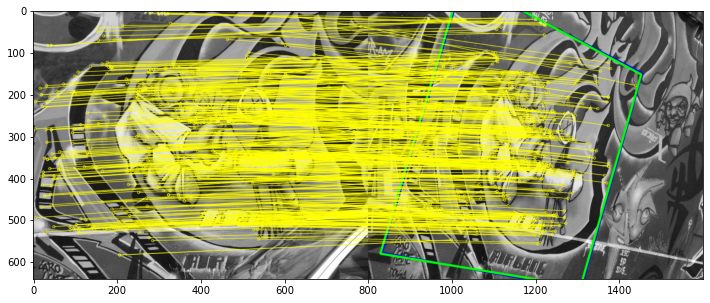

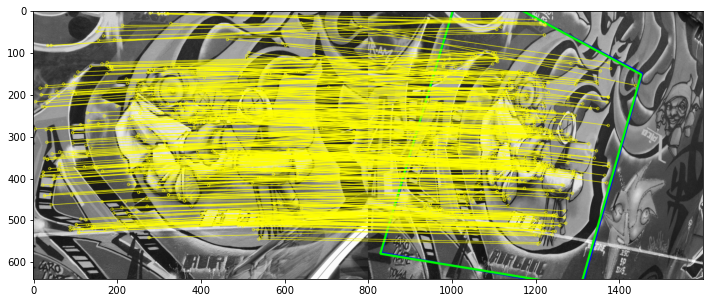

In [5]:
def get_probabilities(tentatives):
    probabilities = []
    # Since the correspondences are assumed to be ordered by their SNN ratio a priori,
    # we just assign a probability according to their order.
    for i in range(len(tentatives)):
        probabilities.append(1.0 - i / len(tentatives))
    return probabilities
    
def verify_cv2(kps1, kps2, tentatives):
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,1,2)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 2.0)
    print (deepcopy(mask).astype(np.float32).sum(), 'inliers found')
    return H, mask

def verify_pymagsac(kps1, kps2, tentatives, use_magsac_plus_plus, h1, w1, h2, w2, sampler_id):
    correspondences = np.float32([ (kps1[m.queryIdx].pt + kps2[m.trainIdx].pt) for m in tentatives ]).reshape(-1,4)
    probabilities = []
    
    # NG-RANSAC and AR-Sampler require an inlier probability to be provided for each point.
    # Since deep learning-based prediction is not applied here, we calculate the probabilities
    # from the SNN ratio ranks.  
    if sampler_id == 3 or sampler_id == 4:
        probabilities = get_probabilities(tentatives)

    H, mask = pymagsac.findHomography(
        np.ascontiguousarray(correspondences), 
        w1, h1, w2, h2,
        probabilities = probabilities,
        sampler = sampler_id,
        use_magsac_plus_plus = use_magsac_plus_plus,
        sigma_th = 2.0)
    print (deepcopy(mask).astype(np.float32).sum(), 'inliers found')
    return H, mask

print("Note that the inlier number does not determine the quality of the solution since MAGSAC and MAGSAC++ does not return inliers. The ones shown are selected by using a dummy threshold.")

t=time()
cv2_H, cv2_mask = verify_cv2(kps1,kps2,tentatives)
print (time()-t, ' sec cv2')

t=time()
magpp_H, magpp_mask = verify_pymagsac(kps1, kps2, tentatives, True,
    img1.shape[0], img1.shape[1], img2.shape[0], img2.shape[1], 2)
print (time()-t, ' sec magsac++')

t=time()
mag_H, mag_mask = verify_pymagsac(kps1, kps2, tentatives, False,
    img1.shape[0], img1.shape[1], img2.shape[0], img2.shape[1], 2)
print (time()-t, ' sec magsac')

draw_matches(kps1, kps2, tentatives, img1, img2, cv2_H, cv2_mask)
draw_matches(kps1, kps2, tentatives, img1, img2, magpp_H, magpp_mask)
draw_matches(kps1, kps2, tentatives, img1, img2, mag_H, mag_mask)


Note: the number of inliers does not determine the quality of the solution. 
    This adaptive inlier selection algorithm selects the set of inliers such that they lead 
    to the most similar model after LSQ fitting to the estimated one.
    This might be useful e.g. in SfM pipelines when using MAGSAC or MAGSAC++.
    If more inliers are needed, parameter 'minimum_required_inliers' should be set higher
79 inliers are found by the adaptive strategy
0.11037020971125633 px is the best threshold


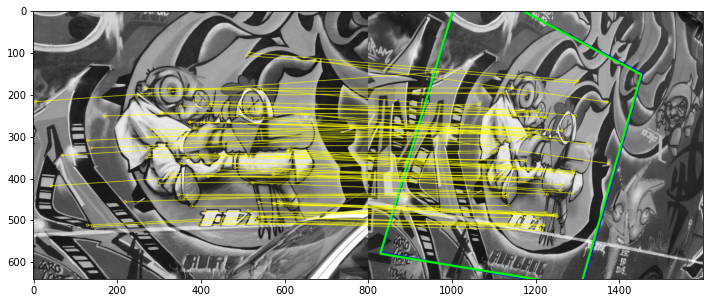

In [6]:
def adaptive_inlier_selection(kps1, kps2, tentatives, model, maximum_threshold, minimum_required_inliers):
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
    
    mask, inlier_number, best_threshold = pymagsac.adaptiveInlierSelection(
        np.ascontiguousarray(src_pts), 
        np.ascontiguousarray(dst_pts), 
        np.ascontiguousarray(model), 
        maximumThreshold = maximum_threshold, # An upper bound for the threshold, this speeds up the procedure, but it should work with infinity as well
        problemType = 0, # 0 stands for homography fitting
        minimumInlierNumber = minimum_required_inliers)
    
    return mask, inlier_number, best_threshold

mask, inlier_number, best_threshold = adaptive_inlier_selection(kps1, kps2, tentatives, magpp_H, 50.0, 20)
draw_matches(kps1, kps2, tentatives, img1, img2, mag_H, mask)

print("""Note: the number of inliers does not determine the quality of the solution. 
    This adaptive inlier selection algorithm selects the set of inliers such that they lead 
    to the most similar model after LSQ fitting to the estimated one.
    This might be useful e.g. in SfM pipelines when using MAGSAC or MAGSAC++.
    If more inliers are needed, parameter 'minimum_required_inliers' should be set higher""")
print(inlier_number, 'inliers are found by the adaptive strategy')
print(best_threshold, 'px is the best threshold')

    